This code runs the ordinal model analysis of the first clips from each observation.

In [38]:
# Load packages
#install.packages("ordinal", lib = "/Users/blaircostelloe/opt/anaconda3/lib/R/library", repos='http://cran.us.r-project.org')
#install.packages("sure", lib = "/Users/blaircostelloe/opt/anaconda3/lib/R/library", repos='http://cran.us.r-project.org')
#install.packages("car", lib = "/Users/blaircostelloe/opt/anaconda3/lib/R/library", repos='http://cran.us.r-project.org')
require(ordinal, lib.loc = "/Users/blaircostelloe/opt/anaconda3/lib/R/library")
require(sure, lib.loc = "/Users/blaircostelloe/opt/anaconda3/lib/R/library")
require(car, lib.loc = "/Users/blaircostelloe/opt/anaconda3/lib/R/library")

In [40]:
# Load and set up data
df <- read.csv("data/first_clips.csv")

# Change group_behavior to an ordered factor
df$group_behavior <-factor(df$group_behavior, ordered = TRUE)

# Define order of categorical variables
df$young_present <-factor(df$young_present, levels = c('False', 'True'))
df$site <-factor(df$site, levels = c('mpala', 'opc'))
df$species <-factor(df$species, levels = c('imp', 'pz', 'gz', 'buf'))

# Drop unneeded variables
df <-subset(df, select = -c(date, obs_ascent, approach_speed_mean,
                           approach_speed_max, approach_duration_minutes,
                           exchange_duration, takeoff_time, landing_time, 
                           temperature_c, max_windspeed, cloud_cover_., humidity_., group_downwind))

For the first step, I want to include the effect of habitat bushiness, which is not available for observations from the Ol Pejeta (opc) field site. So I keep only data from the mpala field site. I also drop buffalo since they have no 0 scores (and thus prevent the model from converging).

I standardize the numerical variables by subtracting the mean value and dividing by the standard deviation.

There were very few response level 3s, so I combine response levels 2 and 3.

In [41]:
mpala <-df[(df$site == 'mpala'),]
mpala <-mpala[!(mpala$species == 'buf'),]

# drop rows with missing data
mpala <- mpala[complete.cases(mpala),]

# standardize numerical variables
mpala$group_size_spp <- (mpala$group_size_spp - mean(mpala$group_size_spp))/sd(mpala$group_size_spp)
mpala$group_size_total <- (mpala$group_size_total - mean(mpala$group_size_total))/sd(mpala$group_size_total)
mpala$bushiness_100m <- (mpala$bushiness_100m - mean(mpala$bushiness_100m))/sd(mpala$bushiness_100m)
mpala$clip_start_ascent_adj <- (mpala$clip_start_ascent_adj - mean(mpala$clip_start_ascent_adj))/sd(mpala$clip_start_ascent_adj)
mpala$mean_windspeed <- (mpala$mean_windspeed - mean(mpala$mean_windspeed))/sd(mpala$mean_windspeed)
mpala$launch_dist <- (mpala$launch_dist - mean(mpala$launch_dist))/sd(mpala$launch_dist)
mpala$wind_speed_ms <- (mpala$wind_speed_ms - mean(mpala$wind_speed_ms))/sd(mpala$wind_speed_ms)

# combine response levels 2 & 3
mpala$group_behavior[mpala$group_behavior ==3] <-2

# drop unneeded levels
mpala <- droplevels(mpala)

Build the initial full model.

In [42]:
M1 <- clm(group_behavior ~ other_spp + group_size_spp + young_present + bushiness_100m +
          clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed + species,
          data = mpala)
summary(M1)

Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”


formula: 
group_behavior ~ other_spp + group_size_spp + young_present + bushiness_100m + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed + species
data:    mpala

 link  threshold nobs logLik  AIC    niter max.grad cond.H 
 logit flexible  330  -280.08 584.16 4(0)  2.64e-07 4.9e+01

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
other_sppTrue           0.1334     0.2783   0.479   0.6316    
group_size_spp          0.3960     0.1690   2.343   0.0191 *  
young_presentTrue      -0.4417     0.2833  -1.559   0.1190    
bushiness_100m         -0.3424     0.1595  -2.147   0.0318 *  
clip_start_ascent_adj  -0.2364     0.1727  -1.369   0.1711    
launch_dist            -0.7661     0.1766  -4.338 1.44e-05 ***
wind_speed_ms           0.2345     0.1473   1.592   0.1114    
mean_windspeed         -0.2714     0.1410  -1.925   0.0542 .  
speciespz               2.0834     0.4270   4.880 1.06e-06 ***
speciesgz               2.1056     0.4066   5.178 2

Perform model validation by inspecting surrogate residuals

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



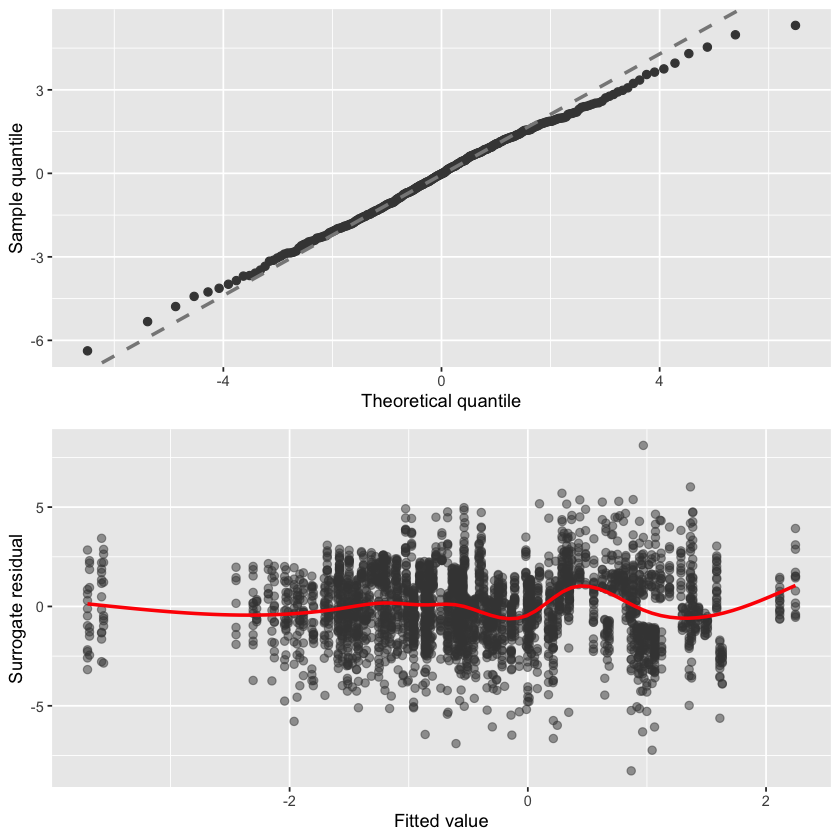

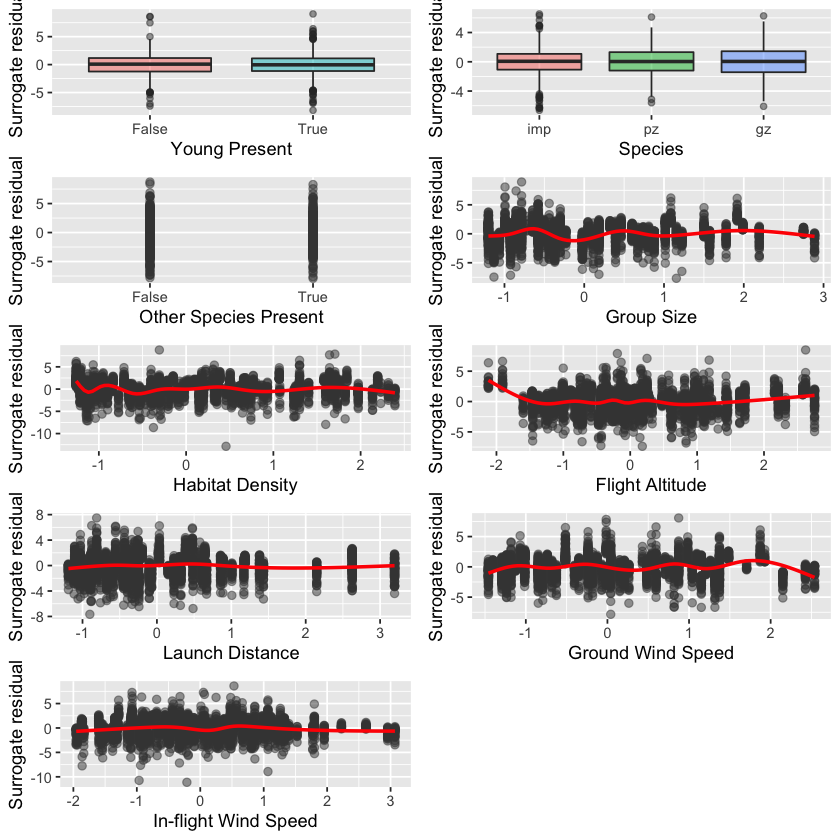

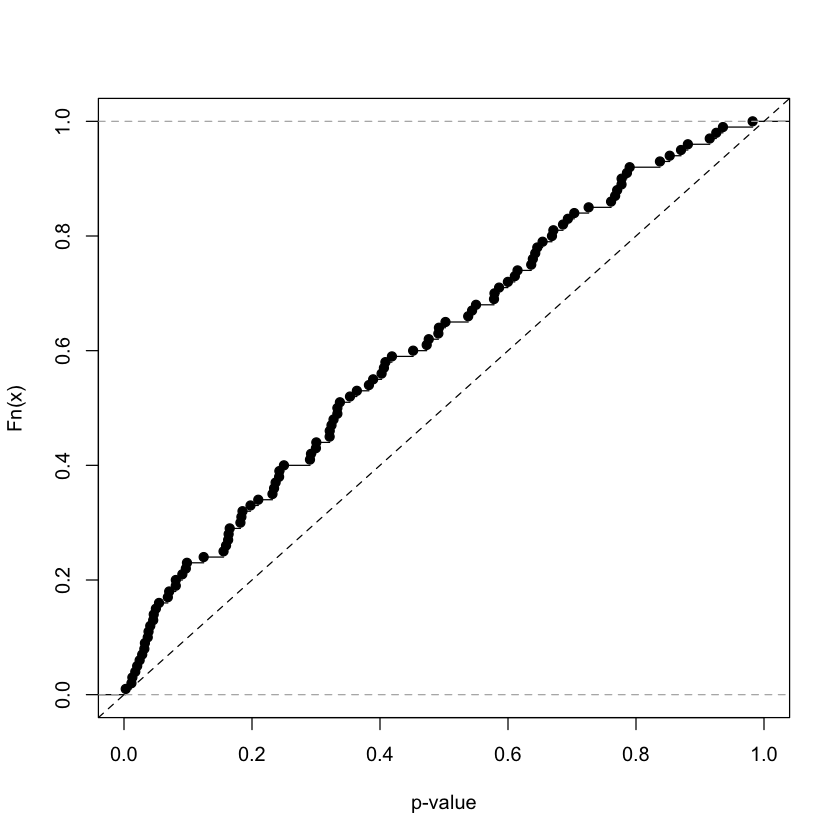

In [43]:
set.seed(1000)
# plot qq plot of residuals and plot residuals by fitted values
grid.arrange(autoplot.clm(M1, nsim = 10, what = 'qq'),
             autoplot.clm(M1, nsim = 10, what = 'fitted', alpha = 0.5),
             ncol = 1)

grid.arrange(
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$young_present, xlab = 'Young Present', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$species, xlab = 'Species', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$other_spp, xlab = 'Other Species Present', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$group_size_spp, xlab = 'Group Size', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$bushiness_100m, xlab = 'Habitat Density', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$clip_start_ascent_adj, xlab = 'Flight Altitude', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$launch_dist, xlab = 'Launch Distance', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$wind_speed_ms, xlab = 'Ground Wind Speed', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$mean_windspeed, xlab = 'In-flight Wind Speed', alpha = 0.5),
     ncol = 2
)

# Kolmogorov-Smirnov goodness-of-fit test.
plot(gof(M1, nsim = 100, test = "ks"), main = "")

Validate the model assumptions (proportional odds assumption and no collinearity)

In [44]:
nominal_test(M1)

Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(

,Df,logLik,AIC,LRT,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,-280.0817,584.1635,NA,NA
other_spp,1,-277.2665,580.5330,5.63047264,1.765087e-02
group_size_spp,1,-273.6350,573.2700,12.89345572,3.297330e-04
young_present,1,-280.0650,586.1300,0.03349439,8.547865e-01
bushiness_100m,1,-276.6439,579.2878,6.87564210,8.737836e-03
clip_start_ascent_adj,1,-275.9674,577.9348,8.22867925,4.123353e-03
launch_dist,1,-279.3104,584.6209,1.54260904,2.142299e-01
wind_speed_ms,1,-279.5361,585.0722,1.09130083,2.961832e-01
mean_windspeed,1,-278.7023,583.4046,2.75888041,9.671590e-02


The nominal test indicates that species, group size, bushiness, other_spp, and flight altitude violate the proportional odds assumption (POA). This needs to be examined directly.
We build two separate binary logistic regression models, one for each response threshold, so we can look at the odds ratios and assess whether they are consistent for each variable across thresholds.

In [45]:
# create binarized response variables
mpala$response0vs12 <- ifelse(mpala$group_behavior == 0, 0, 1)
mpala$response01vs2 <- ifelse(mpala$group_behavior == 2, 1, 0)

bin0vs12 <- glm(response0vs12 ~ group_size_spp + other_spp + young_present + bushiness_100m
                + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed
                + species, family = binomial(link = 'logit'), data = mpala)
bin01vs2 <- glm(response01vs2 ~ group_size_spp + other_spp + young_present + bushiness_100m
                + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed
                + species, family = binomial(link = 'logit'), data = mpala)

summary(bin0vs12)
summary(bin01vs2)


Call:
glm(formula = response0vs12 ~ group_size_spp + other_spp + young_present + 
    bushiness_100m + clip_start_ascent_adj + launch_dist + wind_speed_ms + 
    mean_windspeed + species, family = binomial(link = "logit"), 
    data = mpala)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9050  -0.9667  -0.6353   1.0586   1.8969  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.07210    0.26128  -4.103 4.07e-05 ***
group_size_spp         0.45211    0.18510   2.443   0.0146 *  
other_sppTrue         -0.01201    0.29435  -0.041   0.9675    
young_presentTrue     -0.37642    0.29385  -1.281   0.2002    
bushiness_100m        -0.37838    0.15827  -2.391   0.0168 *  
clip_start_ascent_adj -0.28421    0.16799  -1.692   0.0907 .  
launch_dist           -0.70869    0.17906  -3.958 7.56e-05 ***
wind_speed_ms          0.12115    0.15129   0.801   0.4233    
mean_windspeed        -0.18682    0.14586  -1.281   0.2002   


Call:
glm(formula = response01vs2 ~ group_size_spp + other_spp + young_present + 
    bushiness_100m + clip_start_ascent_adj + launch_dist + wind_speed_ms + 
    mean_windspeed + species, family = binomial(link = "logit"), 
    data = mpala)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5589  -0.4586  -0.3045  -0.1686   2.4069  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -3.8816     0.5102  -7.608 2.78e-14 ***
group_size_spp          0.5474     0.2979   1.837  0.06615 .  
other_sppTrue           0.6193     0.3780   1.638  0.10132    
young_presentTrue      -0.3217     0.4128  -0.779  0.43569    
bushiness_100m         -0.1261     0.2036  -0.620  0.53557    
clip_start_ascent_adj  -0.2017     0.2321  -0.869  0.38479    
launch_dist            -0.9194     0.2902  -3.169  0.00153 ** 
wind_speed_ms           0.4644     0.2166   2.144  0.03207 *  
mean_windspeed         -0.5413     0.2250  -2.406  0.01613 * 

To get the odds ratios we exponentiate the coefficient estimates (logits)

In [46]:
OR_0vs12 <- exp(coef(bin0vs12))
OR_01vs2 <- exp(coef(bin01vs2))
data.frame(OR_0vs12, OR_01vs2)

,OR_0vs12,OR_01vs2
,<dbl>,<dbl>
(Intercept),0.3422883,0.02061688
group_size_spp,1.5716295,1.72874831
other_sppTrue,0.9880666,1.85761818
young_presentTrue,0.6863123,0.72488249
bushiness_100m,0.6849685,0.88149749
clip_start_ascent_adj,0.7526061,0.81734682
launch_dist,0.4922910,0.39874275
wind_speed_ms,1.1287886,1.59098072
mean_windspeed,0.8295931,0.58201816


The odds ratios for species are drastically different between the two models. Therefore, we create a partial proportional odds model with the POA relaxed for the species variable.

In [47]:
M1.2 <- clm(group_behavior ~ group_size_spp + other_spp + young_present + bushiness_100m +
            clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed,
            nominal = ~ species,
            data = mpala)
summary(M1.2)

Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”


formula: 
group_behavior ~ group_size_spp + other_spp + young_present + bushiness_100m + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed
nominal: ~species
data:    mpala

 link  threshold nobs logLik  AIC    niter max.grad cond.H 
 logit flexible  330  -263.43 554.86 7(1)  9.56e-08 1.9e+02

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
group_size_spp         0.422692   0.171540   2.464   0.0137 *  
other_sppTrue          0.009346   0.276716   0.034   0.9731    
young_presentTrue     -0.379227   0.282350  -1.343   0.1792    
bushiness_100m        -0.259928   0.158625  -1.639   0.1013    
clip_start_ascent_adj -0.259570   0.173647  -1.495   0.1350    
launch_dist           -0.690525   0.176691  -3.908  9.3e-05 ***
wind_speed_ms          0.220874   0.146325   1.509   0.1312    
mean_windspeed        -0.282923   0.141455  -2.000   0.0455 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Threshold coefficients:
     

In [48]:
nominal_test(M1.2)

Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(

,Df,logLik,AIC,LRT,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,-263.4319,554.8638,NA,NA
group_size_spp,1,-262.9114,555.8228,1.0409264,0.3076061203
other_spp,1,-258.2944,546.5888,10.2749489,0.0013484860
young_present,1,-262.9782,555.9563,0.9074187,0.3408002463
bushiness_100m,NA,NA,NA,NA,NA
clip_start_ascent_adj,1,-261.7922,553.5843,3.2794073,0.0701542584
launch_dist,1,-257.8109,545.6218,11.2419901,0.0007996737
wind_speed_ms,1,-261.9758,553.9516,2.9121489,0.0879146655
mean_windspeed,NA,NA,NA,NA,NA


Some continuous variables still fail the nominal test, but examination of the odds ratios for the binary logistic models does not indicate that relaxing the POA for these variables is warranted.

To test for multicollinearity among the predictor varaibles, we create a linea regression model with a dummy numerical response variable and then run the VIF (variance inflation factor) test.

In [49]:
mpala$group_behavior_num <- as.numeric(mpala$group_behavior)

lmfit <- lm(group_behavior_num ~ group_size_spp + other_spp + young_present + launch_dist +
            bushiness_100m + clip_start_ascent_adj + wind_speed_ms + mean_windspeed +
            species, data = mpala)

vif(lmfit)

,GVIF,Df,GVIF^(1/(2*Df))
group_size_spp,2.156693,1,1.468568
other_spp,1.351000,1,1.162325
young_present,1.487176,1,1.219498
launch_dist,1.824800,1,1.350852
bushiness_100m,1.693901,1,1.301500
clip_start_ascent_adj,1.789781,1,1.337827
wind_speed_ms,1.644971,1,1.282564
mean_windspeed,1.503658,1,1.226237
species,2.555782,2,1.264390


No values in the last column are over 2, so there is no violation of multicollinearity (source: https://stats.stackexchange.com/questions/70679/which-variance-inflation-factor-should-i-be-using-textgvif-or-textgvif).

So the final model is M1.2

The bushiness variable does not have a significant effect in M1.2. Therefore, we will run another model that doesn't include bushiness so that we can keep some of the data we discarded earlier (data from Ol Pejeta and from Mpala observations that had no landscape maps).

First, we'll clean up the dataframe.

In [50]:
df2 <-df[!(df$species =='buf'),]

# drop unneeded variables
df2 <- subset(df2, select = -bushiness_100m)

# drop rows with missing data
df2 <- df2[complete.cases(df2),]

# standardize numerical variables
df2$group_size_spp <- (df2$group_size_spp - mean(df2$group_size_spp))/sd(df2$group_size_spp)
df2$group_size_total <- (df2$group_size_total - mean(df2$group_size_total))/sd(df2$group_size_total)
df2$clip_start_ascent_adj <- (df2$clip_start_ascent_adj - mean(df2$clip_start_ascent_adj))/sd(df2$clip_start_ascent_adj)
df2$mean_windspeed <- (df2$mean_windspeed - mean(df2$mean_windspeed))/sd(df2$mean_windspeed)
df2$launch_dist <- (df2$launch_dist - mean(df2$launch_dist))/sd(df2$launch_dist)
df2$wind_speed_ms <- (df2$wind_speed_ms - mean(df2$wind_speed_ms))/sd(df2$wind_speed_ms)

# combine response levels 2 & 3
df2$group_behavior[df2$group_behavior ==3] <-2

# drop unneeded levels
df2 <- droplevels(df2)

summary(df2)

 observation           site        flight          species   group_size_spp   
 Length:375         mpala:339   Length:375         imp:195   Min.   :-1.1884  
 Class :character   opc  : 36   Class :character   pz :106   1st Qu.:-0.8326  
 Mode  :character               Mode  :character   gz : 74   Median :-0.3344  
                                                             Mean   : 0.0000  
                                                             3rd Qu.: 0.6619  
                                                             Max.   : 3.0104  
 group_size_total  young_present group_behavior  launch_dist     
 Min.   :-1.4190   False:179     0:219          Min.   :-1.2140  
 1st Qu.:-0.8154   True :196     1: 85          1st Qu.:-0.7154  
 Median :-0.2873                 2: 71          Median :-0.3301  
 Mean   : 0.0000                                Mean   : 0.0000  
 3rd Qu.: 0.6181                                3rd Qu.: 0.5077  
 Max.   : 2.8815                                Max

Build the model

In [51]:
M2 <- clm(group_behavior ~ group_size_spp + other_spp + young_present + site +
          clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed + species,
          data = df2)
summary(M2)

Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”


formula: 
group_behavior ~ group_size_spp + other_spp + young_present + site + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed + species
data:    df2

 link  threshold nobs logLik  AIC    niter max.grad cond.H 
 logit flexible  375  -324.21 672.43 4(0)  1.78e-07 4.5e+01

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
group_size_spp         0.44644    0.15441   2.891  0.00384 ** 
other_sppTrue          0.09363    0.25084   0.373  0.70895    
young_presentTrue     -0.59685    0.26245  -2.274  0.02296 *  
siteopc                0.30856    0.42157   0.732  0.46421    
clip_start_ascent_adj -0.28050    0.15748  -1.781  0.07489 .  
launch_dist           -0.60699    0.14971  -4.054 5.03e-05 ***
wind_speed_ms          0.24661    0.13322   1.851  0.06414 .  
mean_windspeed        -0.22967    0.13173  -1.744  0.08124 .  
speciespz              2.47010    0.35128   7.032 2.04e-12 ***
speciesgz              2.15159    0.38552   5.581 2.39e-08 ***


Perform model validation by inspecting surrogate residuals

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



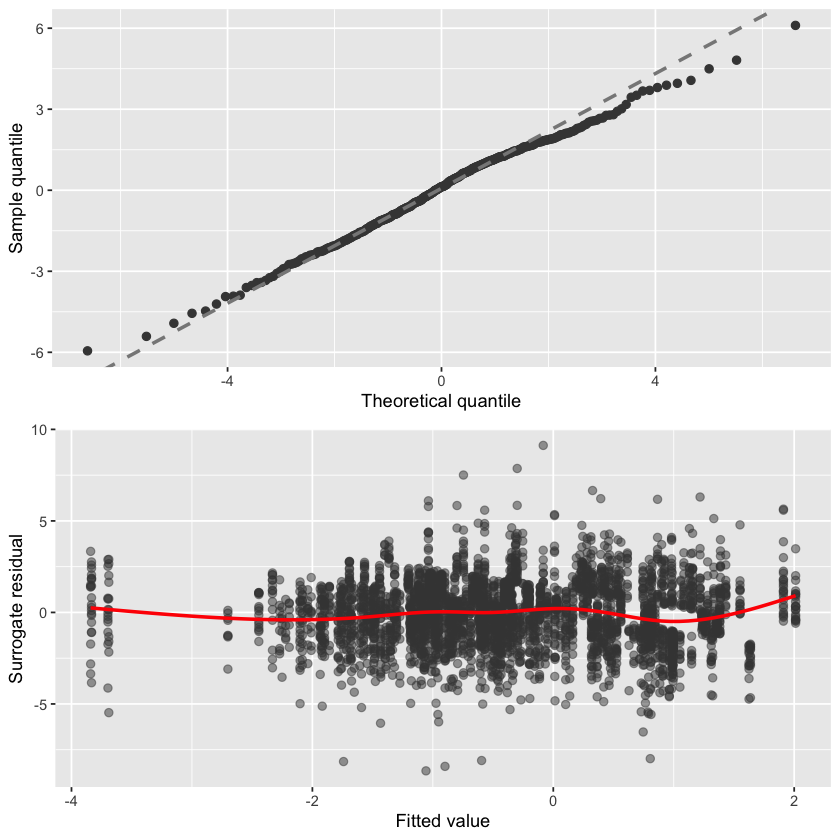

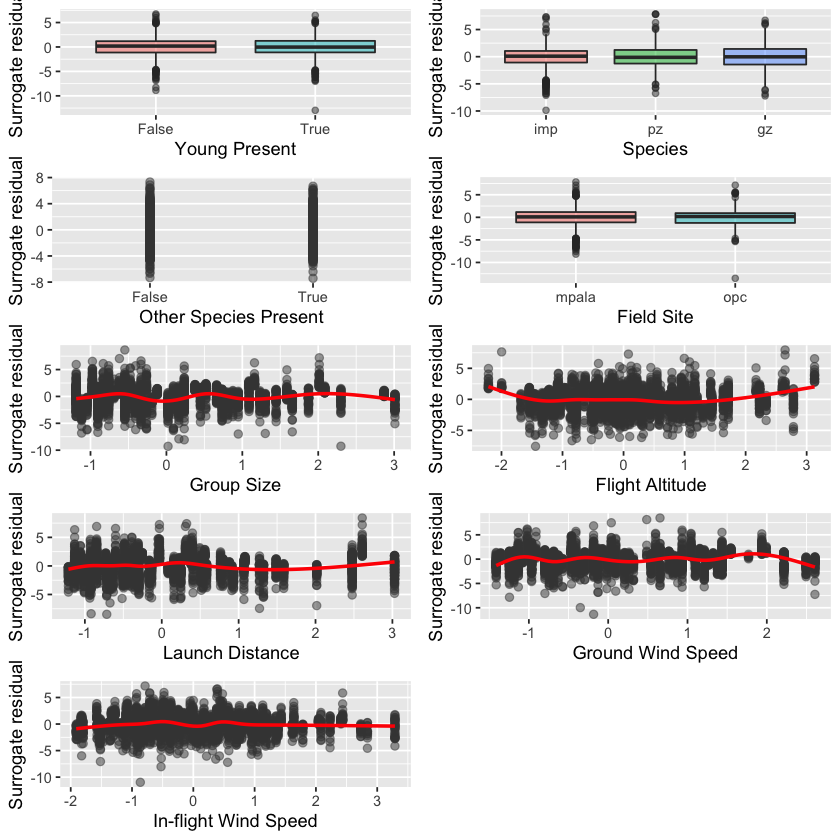

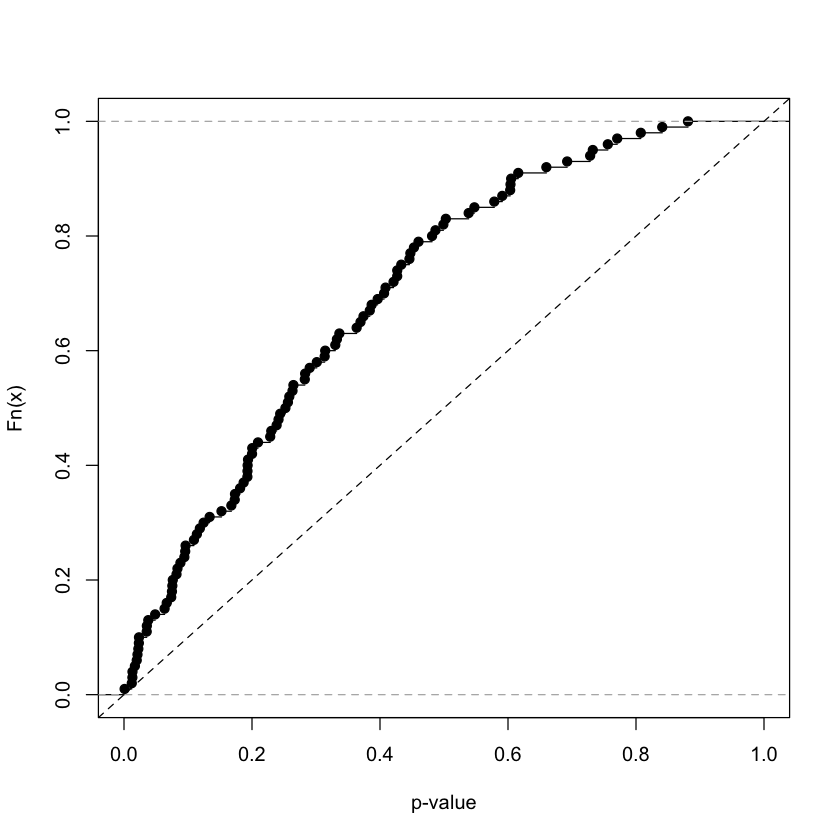

In [52]:
set.seed(1000) # for reproducibility
# plot qq plot of residuals and plot residuals by fitted values
grid.arrange(
  autoplot.clm(M2, nsim = 10, what = 'qq'),
  autoplot.clm(M2, nsim = 10, what = 'fitted', alpha = 0.5),
  ncol = 1
)

grid.arrange(
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$young_present, xlab = 'Young Present', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$species, xlab = 'Species', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$other_spp, xlab = 'Other Species Present', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$site, xlab = 'Field Site', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$group_size_spp, xlab = 'Group Size', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$clip_start_ascent_adj, xlab = 'Flight Altitude', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$launch_dist, xlab = 'Launch Distance', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$wind_speed_ms, xlab = 'Ground Wind Speed', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$mean_windspeed, xlab = 'In-flight Wind Speed', alpha = 0.5),
     ncol = 2
)

# Kolmogorov-Smirnov goodness-of-fit test.
plot(gof(M2, nsim = 100, test = "ks"), main = "")

Check POA and multicollinearity

In [53]:
nominal_test(M2)

Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(

,Df,logLik,AIC,LRT,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,-324.2145,672.4290,NA,NA
group_size_spp,1,-317.2731,660.5463,1.388274e+01,1.945774e-04
other_spp,1,-320.2010,666.4020,8.026962e+00,4.608606e-03
young_present,1,-324.2142,674.4284,6.294317e-04,9.799844e-01
site,1,-321.4780,668.9560,5.472956e+00,1.931293e-02
clip_start_ascent_adj,1,-318.6549,663.3099,1.111910e+01,8.544314e-04
launch_dist,1,-324.2026,674.4053,2.370956e-02,8.776262e-01
wind_speed_ms,1,-324.0807,674.1614,2.676465e-01,6.049149e-01
mean_windspeed,1,-323.4837,672.9674,1.461613e+00,2.266737e-01


Possible violation of the POA by group_size_spp, other_spp, observaiton altitude, and species.
We build two binary logistic regression models so we can look at the odds ratios and assess whether they are consistent for each variable across thresholds.

In [54]:
df2$response0vs12 <- ifelse(df2$group_behavior == 0, 0, 1)
df2$response01vs2 <- ifelse(df2$group_behavior == 2, 1, 0)

bin0vs12_M2 <- glm(response0vs12 ~ group_size_spp + other_spp + young_present + site +
                   clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed +
                   species, family = binomial(link = 'logit'), data = df2)

bin01vs2_M2 <- glm(response01vs2 ~ group_size_spp + other_spp + young_present + site +
                   clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed +
                   species, family = binomial(link = 'logit'), data = df2)

OR_0vs12_M2 <- exp(coef(bin0vs12_M2))
OR_01vs2_M2 <- exp(coef(bin01vs2_M2))

data.frame(OR_0vs12_M2, OR_01vs2_M2)

,OR_0vs12_M2,OR_01vs2_M2
,<dbl>,<dbl>
(Intercept),0.3437060,0.02401406
group_size_spp,1.6028621,1.75153472
other_sppTrue,0.9532967,1.82397659
young_presentTrue,0.5603695,0.58341860
siteopc,0.8829494,3.32964680
clip_start_ascent_adj,0.7462005,0.84513866
launch_dist,0.5890510,0.49238021
wind_speed_ms,1.1984199,1.41546503
mean_windspeed,0.8383822,0.66164969


Species and site seem to be in violation. Site is likely a result of the uneven sample size between the two locations. Let's make a partial proportional odds model with the POA relaxed for species

In [55]:
M2.2 <- clm(group_behavior ~ group_size_spp + other_spp + young_present + site +
            clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed,
            nominal = ~ species, data = df2)

nominal_test(M2.2)

Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(

,Df,logLik,AIC,LRT,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,-306.3976,640.7952,NA,NA
group_size_spp,1,-305.6127,641.2253,1.569846,0.210229330
other_spp,1,-301.1411,632.2823,10.512915,0.001185431
young_present,1,-306.1909,642.3818,0.413357,0.520270522
site,NA,NA,NA,NA,NA
clip_start_ascent_adj,1,-304.6468,639.2937,3.501488,0.061313700
launch_dist,1,-303.4018,636.8035,5.991629,0.014373919
wind_speed_ms,1,-305.7613,641.5226,1.272539,0.259290857
mean_windspeed,NA,NA,NA,NA,NA


There are no values here for site and mean_windspeed because when these variables are set as nominal variables, the odds models do not converge. The models "test" below is M2.2 without these variables. We ran an ANOVA comparison of the models to see if removing these variables has a positive effect on the model. The model is not improved with their removal.

In [56]:
test <- clm(group_behavior ~ group_size_spp + other_spp + young_present +
            clip_start_ascent_adj + launch_dist + wind_speed_ms,
            nominal = ~ species, 
            data = df2)
anova(M2.2, test)

Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”


,no.par,AIC,logLik,LR.stat,df,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
test,12,640.3543,-308.1771,NA,NA,NA
M2.2,14,640.7952,-306.3976,3.559091,2,0.1687148


Test for multicoliniearity using the linear regression model with dummy numerical response.

In [57]:
df2$group_response_num <- as.numeric(df2$group_behavior)

lmfit2 <-lm(group_response_num ~ group_size_spp + other_spp + young_present + launch_dist +
            site + clip_start_ascent_adj + wind_speed_ms + mean_windspeed + species,
            data = df2)

vif(lmfit2)

,GVIF,Df,GVIF^(1/(2*Df))
group_size_spp,2.075410,1,1.440628
other_spp,1.357955,1,1.165313
young_present,1.486914,1,1.219391
launch_dist,1.547179,1,1.243857
site,1.298329,1,1.139442
clip_start_ascent_adj,1.737604,1,1.318182
wind_speed_ms,1.574516,1,1.254797
mean_windspeed,1.418479,1,1.190999
species,2.211331,2,1.219448


No issues with multicolinearity, so we accept model M2.2 as our final model.

In [58]:
summary(M2.2)

formula: 
group_behavior ~ group_size_spp + other_spp + young_present + site + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed
nominal: ~species
data:    df2

 link  threshold nobs logLik  AIC    niter max.grad cond.H 
 logit flexible  375  -306.40 640.80 8(1)  3.02e-13 1.7e+02

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
group_size_spp         0.44831    0.15603   2.873 0.004064 ** 
other_sppTrue          0.03207    0.25023   0.128 0.898012    
young_presentTrue     -0.54792    0.26093  -2.100 0.035743 *  
siteopc                0.27662    0.41731   0.663 0.507419    
clip_start_ascent_adj -0.28872    0.15791  -1.828 0.067491 .  
launch_dist           -0.56660    0.15016  -3.773 0.000161 ***
wind_speed_ms          0.24231    0.13310   1.821 0.068683 .  
mean_windspeed        -0.24357    0.13220  -1.842 0.065416 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Threshold coefficients:
                Estimate S